In [1]:
import meep as mp

Using the materials for gold or SiO2 given in meep.materials was causing the Electric field intensitites to blow up in the simulation, so I used the Drude model for gold and simply put the dielectric constant as the sole parameter for SiO2

Values for Drude model of Au sourced from:  https://www.researchgate.net/publication/234368803_Improved_analytical_fit_of_gold_dispersion_Application_to_the_modeling_of_extinction_spectra_with_a_finite-difference_time-domain_method 

In [2]:
Drude_Au = mp.Medium(
    epsilon=9,
    E_susceptibilities=[mp.DrudeSusceptibility(frequency=2155, gamma=18.36)]
    )
Simple_SiO2 = mp.Medium(
    epsilon=3.9
)


To generate SPPs, I used a Gaussian Source with an $H_z$ component, positioned at (0,0,height) i.e. just on top of the nanorod

This idea to generate SPPs was sourced from this mail thread:

https://www.mail-archive.com/meep-discuss@ab-initio.mit.edu/msg04729.html

In [3]:

radius = 0.2353
height = 0.2646
slab_depth = 1
dpml = 0.25
buffer = 1
total = dpml + buffer + slab_depth + dpml
pml_layers = [mp.PML(dpml, direction=mp.Z)]

cell = mp.Vector3(1, 1, total)
blk = mp.Block(
    size=mp.Vector3(1, 1, slab_depth),
    center=mp.Vector3(0,0,-slab_depth/2.0),
    material=Drude_Au
)
cyl = mp.Cylinder(
    radius=radius,
    height=height,
    center=mp.Vector3(0,0,height/2.0),
    material=Drude_Au
)
geometry= [blk, cyl]
resolution=16

fcen = 0.25  # pulse center frequency
df = 0.8   # pulse freq. width: large df = short impulse
scen = mp.Vector3(0,0,height)
s = [mp.Source(
    src=mp.GaussianSource(fcen, fwidth=df),
    component=mp.Hz,
    center=scen)]
    
sim = mp.Simulation(cell_size=cell,
                geometry=geometry,
                boundary_layers=pml_layers,
                sources=s,
                resolution=resolution,
                default_material=Simple_SiO2
                )

We will first compute the partial band diagram from $\Gamma$ to $X$ using Simulation.run_k_points; I could set the limit on the number of bands when running Harminv on a single point, but couldn't do so for multiple points, so the majority of frequencies found were above the light line (clearly, we are only concerned with the points _below_ the light line)



In [ ]:
sim.restart_fields()
k_points = [
    mp.Vector3(0,0,0), #Gamma
    mp.Vector3(0.5, 0,0), # X
]
k_points = mp.interpolate(20, k_points)
all_freqs = sim.run_k_points(300, k_points)

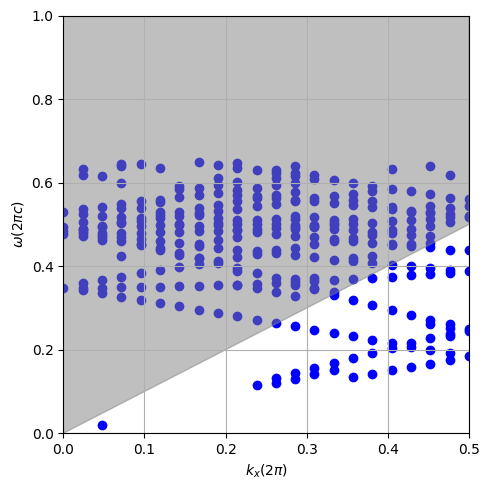

In [5]:
from matplotlib import pyplot as plt
import numpy as np

kx = [k.x for k in k_points]
fig = plt.figure(dpi=100,figsize=(5,5))
ax = plt.subplot(111)
for i in range(len(all_freqs)):
    for ii in range(len(all_freqs[i])):
        plt.scatter(kx[i],np.real(all_freqs[i][ii]),color='b')

ax.fill_between(kx, kx, 2.0, interpolate=True, color='gray', alpha = 0.5)
plt.xlim(0,0.5)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel('$k_x(2\pi)$')
plt.ylabel('$\omega(2\pi c)$')
plt.tight_layout()
plt.show()

Then I did the same computation for the full band structure, and obtained the following results:

In [ ]:
sim.restart_fields()
k_points = [
    mp.Vector3(0,0,0), #Gamma
    mp.Vector3(0,0.5,0), # X
    mp.Vector3(0.5,0.5,0), # M 
    mp.Vector3(0,0,0) # Gamma
]
k_points = mp.interpolate(10, k_points)
all_freqs = sim.run_k_points(300, k_points)


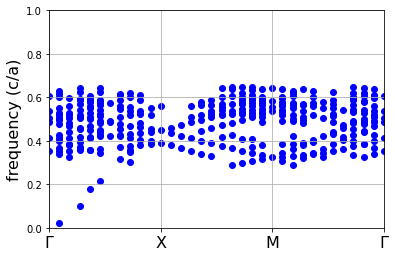

In [ ]:
fig, ax = plt.subplots()
freqs = all_freqs
x = range(len(freqs))
# Plot bands
# Scatter plot for multiple y values, see https://stackoverflow.com/a/34280815/2261298
for xz, z in zip(x, freqs):
    ax.scatter([xz]*len(z), z, color='blue')

ax.set_ylim([0, 1])
ax.set_xlim([x[0], x[-1]])

# line = np.arange(0,10,0.01)
# ax.fill_between(line,line/10.0 , 1.0, interpolate=True, color='gray', alpha = 0.5)

points_in_between = (len(freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'X', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=16)
ax.set_ylabel('frequency (c/a)', size=16)
ax.grid(True)

plt.show()

Clearly, there is no distinct band gap observed in the diagram, so there must a problem with my simulation methodology.  

I have tried several different approaches, but this one gave the "closest" answer: mpb.ModeSolver seems to work for Modes in Dielectric crystal but does not seem to work for SPPs - i get a band diagram coinciding with the light line in that case.

In a nutshell, there are at least two places where I believe an improvement will make the results much better, which I couldn't figure out satisfactorily within the given amount of time: firstly, a better material for gold and SiO2, and a "sure" method of producing SPPs at the metal-dielectric interface.